In [1]:
from paths import *
from utils import *

import re
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.proportion import proportion_confint
%matplotlib inline
sns.set_context('notebook', font_scale=1.4)
sns.set_style("whitegrid")

ALPHA = 0.05

# Diagnosis

## Tables

### GPT3

In [2]:
def preprocess(vignettes_graded: pd.DataFrame) -> pd.DataFrame:
    
    # Remove NA columns added by excel 
    num_null_percol = vignettes_graded.isna().sum(axis=0)
    num_rows = vignettes_graded.shape[0]
    vignettes_graded = vignettes_graded.loc[:, num_null_percol < num_rows]
    
    # Remove NA rows added by excel
    num_null_perrow = vignettes_graded.isna().sum(axis=1)
    num_columns = vignettes_graded.shape[1]
    vignettes_graded = vignettes_graded.loc[num_null_perrow < num_columns]
    
    # Drop null value rows, getting rid of multiple prediction rows
    vignettes_graded = vignettes_graded.dropna().reset_index(drop=True)
    
    vignettes_graded['Top-1'] = vignettes_graded['Top Dx Correct?'] == 'Yes'
    vignettes_graded['Top-3'] = vignettes_graded['Correct Dx in Top-3?'] == 'Yes'
    
    vignettes_graded.drop(["Number of predictions", "Top Predicted Dx", 
                           "Top-3 Predicted Dx", 'Top Dx Correct?',
                           'Correct Dx in Top-3?'], 
                          inplace=True, axis=1)
    
    return vignettes_graded

# Read original vignettes
vignettes20 = parse_vignettes_2020(RAW/'vignettes-2020.tsv').reset_index(drop=True)

# Read the graded vignettes
gpt3_dx_graded = preprocess(
    pd.read_excel(PROCESSED/'vignettes_diagnosis_predictions_instruct_graded.xlsx',
                  sheet_name=1))
# Add triage info
gpt3_dx_graded['Additional Details'] = gpt3_dx_graded['Additional Details'].map(
    lambda s: s+'.' if not s.endswith('.') else s)
problem2triage = vignettes20.set_index('Additional Details')['Correct Triage'].to_dict()
gpt3_dx_graded['Correct Triage'] = gpt3_dx_graded['Additional Details'].map(lambda s: problem2triage[s])

In [3]:
# Aggregate over vignettes
gpt3_dx_perf = gpt3_dx_graded.groupby('Correct Triage')\
    [['Top-1', 'Top-3']].\
    agg([len, sum])
gpt3_dx_perf.loc['All'] = gpt3_dx_perf.sum()
gpt3_dx_perf.rename(columns={'sum': '# Correct', 'len': 'N'}, inplace=True)

# Get confidence intervals
data = []
for i, row in gpt3_dx_perf.iterrows():
    for col in ['Top-1', 'Top-3']:
        n, total = row[col].values
        row.loc[(col, 'LB')], row.loc[(col, 'UB')] =\
            proportion_confint(count=total, nobs=n, alpha=ALPHA, method='wilson')
        row.loc[(col, 'LB')]*= 100; row.loc[(col, 'UB')] *= 100
        row.loc[(col, 'Mean')] = (total/n)*100
    row.name = i
    data.append(row)
    
gpt3_dx_perf = pd.DataFrame(data)
gpt3_dx_perf.sort_index(axis=1, inplace=True)
gpt3_dx_perf

Top-1                                            Top-3  \
          # Correct         LB       Mean     N         UB # Correct   
1-day           7.0  31.951131  58.333333  12.0  80.673969      10.0   
1-week          8.0  39.062209  66.666667  12.0  86.187991      11.0   
Emergent        8.0  39.062209  66.666667  12.0  86.187991       9.0   
Self-care       8.0  39.062209  66.666667  12.0  86.187991      12.0   
All            31.0  50.439057  64.583333  48.0  76.566356      42.0   

                                                    
                  LB        Mean     N          UB  
1-day      55.196914   83.333333  12.0   95.303486  
1-week     64.612009   91.666667  12.0   98.513491  
Emergent   46.769467   75.000000  12.0   91.105833  
Self-care  75.750599  100.000000  12.0  100.000000  
All        75.299542   87.500000  48.0   94.142949

### Physician

In [4]:
# Read dx performance (only top-3 available)
md_dx_perf = pd.read_csv(RAW/'MD-dx.tsv', sep='\t')

# Get triage info
idx2triage = vignettes20['Correct Triage'].to_dict()
md_dx_perf['Correct Triage'] = md_dx_perf['Name'].map(lambda s: idx2triage[
    int(re.findall(r"[\d]+", s)[0]) - 1])

# Calculate aggregate statistics
md_dx_perf['# Correct'] = (md_dx_perf['N'] * md_dx_perf['Accuracy']).map(round)
del md_dx_perf['Accuracy']
md_dx_perf = md_dx_perf.groupby('Correct Triage').agg(sum)
md_dx_perf.loc['All'] = md_dx_perf.sum()

# Get confidence intervals
data = []
for i, row in md_dx_perf.iterrows():
    n, total = row.values
    row.loc['LB'], row.loc['UB'] =\
        proportion_confint(count=total, nobs=n, alpha=ALPHA, method='wilson')
    row.loc['LB']*= 100; row.loc['UB'] *= 100
    row.loc['Mean'] = (total/n)*100
            
    row.name = i
    data.append(row)
    
md_dx_perf = pd.DataFrame(data)
md_dx_perf.columns = pd.MultiIndex.from_product([['Top-3'], md_dx_perf.columns])
md_dx_perf

Top-3                                           
               N # Correct         LB         UB       Mean
1-day      172.0     159.0  87.499282  95.530057  92.441860
1-week     155.0     153.0  95.417912  99.645431  98.709677
Emergent   179.0     169.0  90.023082  96.937501  94.413408
Self-care  160.0     156.0  93.749011  99.023601  97.500000
All        666.0     637.0  93.816405  96.951342  95.645646

### Human

In [5]:
# Read dx performance (only top-3 available)
human_dx_perf = pd.read_csv(RAW/'human-dx.tsv', sep='\t')

# Remove pre-evaluations
human_dx_perf = human_dx_perf[~human_dx_perf["Name"].map(lambda s: 'pre' in s)].\
    reset_index(drop=True)

# Separate Top-1 and Top-3 rows
top1 = human_dx_perf.loc[~human_dx_perf['Name'].str.contains("any")]
top1['Name'] = top1['Name'].map(lambda s: s.split("post")[0])

top3 = human_dx_perf.loc[human_dx_perf['Name'].str.contains("any")]
top3['Name'] = top3['Name'].map(lambda s: s.split("any")[0])

# Concat with multindex (similar to gpt3 perf)
human_dx_perf = top1.merge(top3, on='Name', how='outer', suffixes=("_top1", "_top3"))
assert (human_dx_perf["N_top1"]-human_dx_perf["N_top3"]).sum() == 0
human_dx_perf.set_index("Name", inplace=True)
human_dx_perf.columns = pd.MultiIndex.from_product([["Top-1", "Top-3"], ["N", "Accuracy"]])
for col in ["Top-1", "Top-3"]:
    human_dx_perf[(col, "# Correct")] = (human_dx_perf[(col, "N")] *  human_dx_perf[(col, "Accuracy")]).map(round)
    del human_dx_perf[(col, "Accuracy")]
    
# Add triage info
idx2triage = vignettes20['Correct Triage'].to_dict()
human_dx_perf['Correct Triage'] = human_dx_perf.index.map(lambda s: idx2triage[
    int(re.findall(r"[\d]+", s)[0]) - 1])

# Aggregate over vignettes
human_dx_perf = human_dx_perf.groupby('Correct Triage').agg(sum)
human_dx_perf.loc['All'] = human_dx_perf.sum()

# Get confidence intervals
data = []
for i, row in human_dx_perf.iterrows():
    for col in ['Top-1', 'Top-3']:
        n, total = row[col].values
        row.loc[(col, 'LB')], row.loc[(col, 'UB')] =\
            proportion_confint(count=total, nobs=n, alpha=ALPHA, method='wilson')
        row.loc[(col, 'LB')]*= 100; row.loc[(col, 'UB')] *= 100
        row.loc[(col, 'Mean')] = (total/n)*100
    row.name = i
    data.append(row)
    
human_dx_perf = pd.DataFrame(data)
human_dx_perf.sort_index(1, inplace=True)
human_dx_perf

/tmp/ipykernel_24902/3136293482.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top1['Name'] = top1['Name'].map(lambda s: s.split("post")[0])
/tmp/ipykernel_24902/3136293482.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top3['Name'] = top3['Name'].map(lambda s: s.split("any")[0])
/home/rt156/.local/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, ax

Top-1                                              Top-3  \
          # Correct         LB       Mean       N         UB # Correct   
1-day         332.0  24.852226  27.280197  1217.0  29.851147     507.0   
1-week        573.0  43.059481  45.803357  1251.0  48.572928     741.0   
Emergent      381.0  27.543072  30.000000  1270.0  32.577554     554.0   
Self-care     688.0  51.759751  54.516640  1262.0  57.246116     898.0   
All          1974.0  38.133691  39.480000  5000.0  40.842461    2700.0   

                                                    
                  LB       Mean       N         UB  
1-day      38.920518  41.659819  1217.0  44.451606  
1-week     56.485320  59.232614  1251.0  61.923380  
Emergent   40.917897  43.622047  1270.0  46.364665  
Self-care  68.596189  71.156894  1262.0  73.589189  
All        52.615994  54.000000  5000.0  55.377864

## Figures

In [6]:
dx_perf = pd.concat([human_dx_perf, gpt3_dx_perf, md_dx_perf])
dx_perf['Respondent'] = ['Lay individuals (with Internet Access)']*5 +\
    ['GPT-3']*5 +\
    ['Physicians']*5
dx_perf.index.name = "Case Acuity"
dx_perf.reset_index(inplace=True)

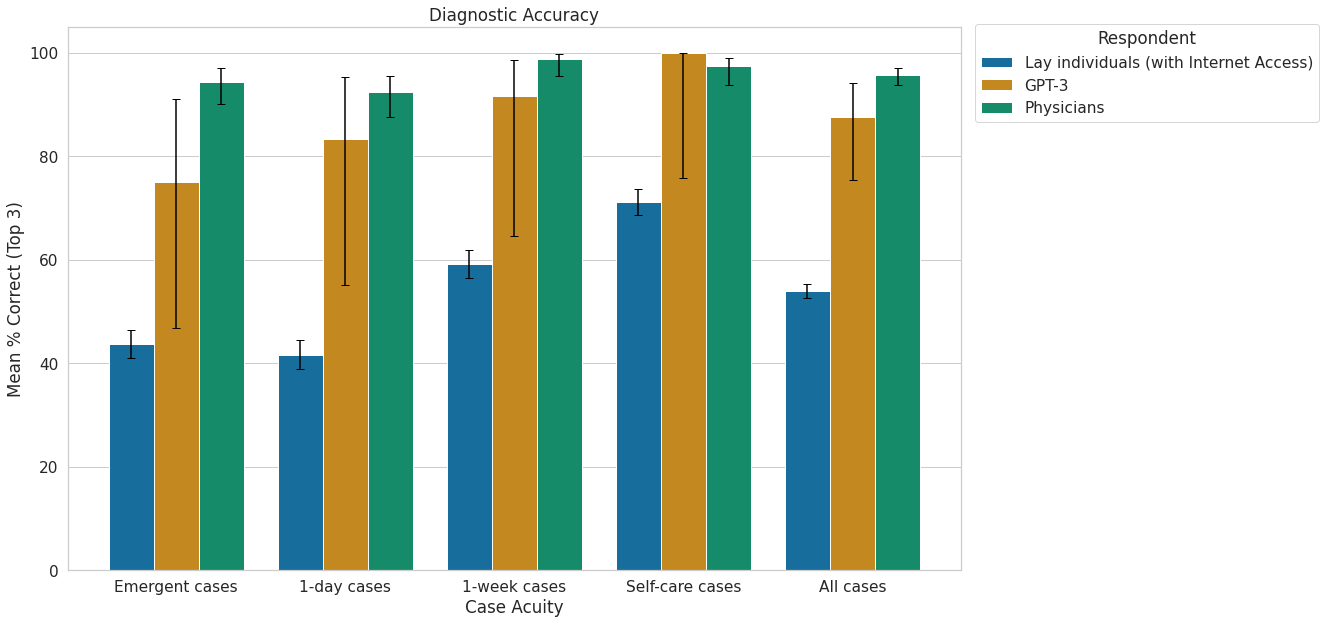

In [7]:
row_order = ["Emergent", "1-day", "1-week", "Self-care", "All"]

fig, ax = plt.subplots(figsize=(16, 10))
g = sns.barplot(data=dx_perf, 
            x=('Case Acuity', ''), 
            y=('Top-3', 'Mean'),
            hue=( 'Respondent', ''),
            ax=ax,
            order=row_order,
            palette="colorblind"
           )
g.legend(loc='upper right', bbox_to_anchor=(1.41, 1.02), title="Respondent")
g.set_xlabel("Case Acuity")
g.set_ylabel("Mean % Correct (Top 3)")
g.set_xticklabels([a.get_text() + " cases" for a in ax.get_xticklabels()])
g.set_title("Diagnostic Accuracy")

tmp = dx_perf.set_index(["Case Acuity", "Respondent"]).\
    loc[[(case, respondent.get_text()) for respondent in ax.legend_.get_texts() for case in row_order]]
tmp[("Top-3", "LB")] = -(tmp[("Top-3", "LB")]-tmp[("Top-3", "Mean")])
tmp[("Top-3", "UB")] = tmp[("Top-3", "UB")] - tmp[("Top-3", "Mean")]
                                                     
ax.errorbar(x=[patch.get_x()+patch.get_width()/2 for patch in ax.patches], 
            y=[patch.get_height() for patch in ax.patches], 
            yerr=tmp[[("Top-3", "LB"), ("Top-3", "UB")]].values.T,
            ls='none', fmt='k', capsize=4);

# Triage

## Tables

### GPT-3

In [8]:
# def preprocess(vignettes_pred: pd.DataFrame) -> pd.DataFrame:
    
#     # Remove NA columns
#     vignettes_pred = vignettes_pred.dropna().reset_index(drop=True)
#     vignettes_pred['Correct'] = vignettes_pred['Correct(Yes/No)'] == 'Yes'
    
#     # Drop redundant columns
#     vignettes_pred.drop(["Predicted Triage", "Number of Predictions", "Average Probability", 'Correct(Yes/No)'], 
#                           inplace=True, axis=1)
    
#     return vignettes_pred

def preprocess(vignettes_pred: pd.DataFrame) -> pd.DataFrame:
    
    # Keep the most common prediction
    vignettes_pred = vignettes_pred.sort_values(
    ["Additional Details", "Problem", "Number of Predictions", "Average Probability"],
    ascending=False).\
    drop_duplicates(["Additional Details", "Problem"], keep="first")
    
    vignettes_pred['Correct'] = vignettes_pred['Correct(Yes/No)'] == "Yes"
    
    # Drop redundant columns
    vignettes_pred.drop(["Predicted Triage", "Number of Predictions", "Average Probability", 'Correct(Yes/No)'], 
                          inplace=True, axis=1)
    
    return vignettes_pred
  
# Dichotomized
gpt3_triage_graded = preprocess(pd.read_excel(
    PROCESSED/'vignettes20_triage_prediction_agg_dichotomized.xlsx',          
    index_col=list(range(4))).reset_index())
ad2triage = vignettes20.set_index('Additional Details')['Correct Triage'].to_dict()
gpt3_triage_graded["Correct Triage"] = gpt3_triage_graded['Additional Details'].map(
    lambda s: ad2triage[s]
)

# Exact
# gpt3_triage_graded = preprocess(pd.read_excel(PROCESSED/'vignettes20_triage_prediction_agg_exact.xlsx'))

In [9]:
# Aggregate over vignettes
gpt3_triage_perf = gpt3_triage_graded.groupby('Correct Triage').agg({"Correct": [len, sum]})
gpt3_triage_perf.loc['All'] = gpt3_triage_perf.sum()
gpt3_triage_perf.rename(columns={'sum': '# Correct', 'len': 'N'}, inplace=True)
gpt3_triage_perf = gpt3_triage_perf["Correct"]

# Get confidence intervals
data = []
for i, row in gpt3_triage_perf.iterrows():
    n, total = row.values
    row.loc['LB'], row.loc['UB'] =\
        proportion_confint(count=total, nobs=n, alpha=ALPHA, method='wilson')
    row.loc['LB']*= 100; row.loc['UB'] *= 100
    row.loc['Mean'] = (total/n)*100
    row.name = i
    data.append(row)
    
gpt3_triage_perf = pd.DataFrame(data)
gpt3_triage_perf

,N,# Correct,LB,UB,Mean
1-day,12.0,7.0,31.951131,80.673969,58.333333
1-week,12.0,11.0,64.612009,98.513491,91.666667
Emergent,12.0,8.0,39.062209,86.187991,66.666667
Self-care,12.0,6.0,25.378160,74.621840,50.000000
All,48.0,32.0,52.540110,78.323219,66.666667


### Physician

In [10]:
# Read dx performance (only top-3 available)
md_triage_perf = pd.read_csv(RAW/'MD-triage.tsv', sep='\t')

# Get triage info
idx2triage = vignettes20['Correct Triage'].to_dict()
md_triage_perf['Correct Triage'] = md_triage_perf['Name'].map(lambda s: idx2triage[
    int(re.findall(r"[\d]+", s)[0]) - 1])

# Calculate aggregate statistics
md_triage_perf['# Correct'] = (md_triage_perf['N'] * md_triage_perf['Accuracy']).map(round)
del md_triage_perf['Accuracy']
md_triage_perf = md_triage_perf.groupby('Correct Triage').agg(sum)
md_triage_perf.loc['All'] = md_triage_perf.sum()

# Get confidence intervals
data = []
for i, row in md_triage_perf.iterrows():
    n, total = row.values
    row.loc['LB'], row.loc['UB'] =\
        proportion_confint(count=total, nobs=n, alpha=ALPHA, method='wilson')
    row.loc['LB']*= 100; row.loc['UB'] *= 100
    row.loc['Mean'] = (total/n)*100
            
    row.name = i
    data.append(row)
    
md_triage_perf = pd.DataFrame(data)
md_triage_perf

,N,# Correct,LB,UB,Mean
1-day,172.0,156.0,85.424290,94.192884,90.697674
1-week,155.0,129.0,76.556435,88.288097,83.225806
Emergent,179.0,177.0,96.018280,99.693054,98.882682
Self-care,160.0,146.0,85.849368,94.716321,91.250000
All,666.0,608.0,88.906126,93.202855,91.291291


### Human

In [11]:
# Read dx performance (only top-3 available)
human_triage_perf = pd.read_csv(RAW/'human-triage.tsv', sep='\t')

# Remove pre-evaluations
human_triage_perf = human_triage_perf[~human_triage_perf["Name"].map(lambda s: 'pre' in s)].\
    reset_index(drop=True)

# Add triage info
idx2triage = vignettes20['Correct Triage'].to_dict()
human_triage_perf['Correct Triage'] = human_triage_perf["Name"].map(lambda s: idx2triage[
    int(re.findall(r"[\d]+", s)[0]) - 1])


# Calculate aggregate statistics
human_triage_perf['# Correct'] = (human_triage_perf['N'] * human_triage_perf['Accuracy']).map(round)
del human_triage_perf['Accuracy']
human_triage_perf = human_triage_perf.groupby('Correct Triage').agg(sum)
human_triage_perf.loc['All'] = human_triage_perf.sum()

# Get confidence intervals
data = []
for i, row in human_triage_perf.iterrows():
    n, total = row.values
    row.loc['LB'], row.loc['UB'] =\
        proportion_confint(count=total, nobs=n, alpha=ALPHA, method='wilson')
    row.loc['LB']*= 100; row.loc['UB'] *= 100
    row.loc['Mean'] = (total/n)*100
            
    row.name = i
    data.append(row)
    
human_triage_perf = pd.DataFrame(data)
human_triage_perf

,N,# Correct,LB,UB,Mean
1-day,1217.0,968.0,77.182096,81.711710,79.539852
1-week,1251.0,755.0,57.613327,63.026731,60.351719
Emergent,1270.0,1108.0,85.296388,88.967171,87.244094
Self-care,1262.0,875.0,66.734893,71.816539,69.334390
All,5000.0,3706.0,72.887824,75.315142,74.120000


## Figures

In [12]:
triage_perf = pd.concat([human_triage_perf, gpt3_triage_perf, md_triage_perf])
triage_perf['Respondent'] = ['Lay individuals (with Internet Access)']*5 +\
    ['GPT-3']*5 +\
    ['Physicians']*5
triage_perf.index.name = "Case Acuity"
triage_perf.reset_index(inplace=True)

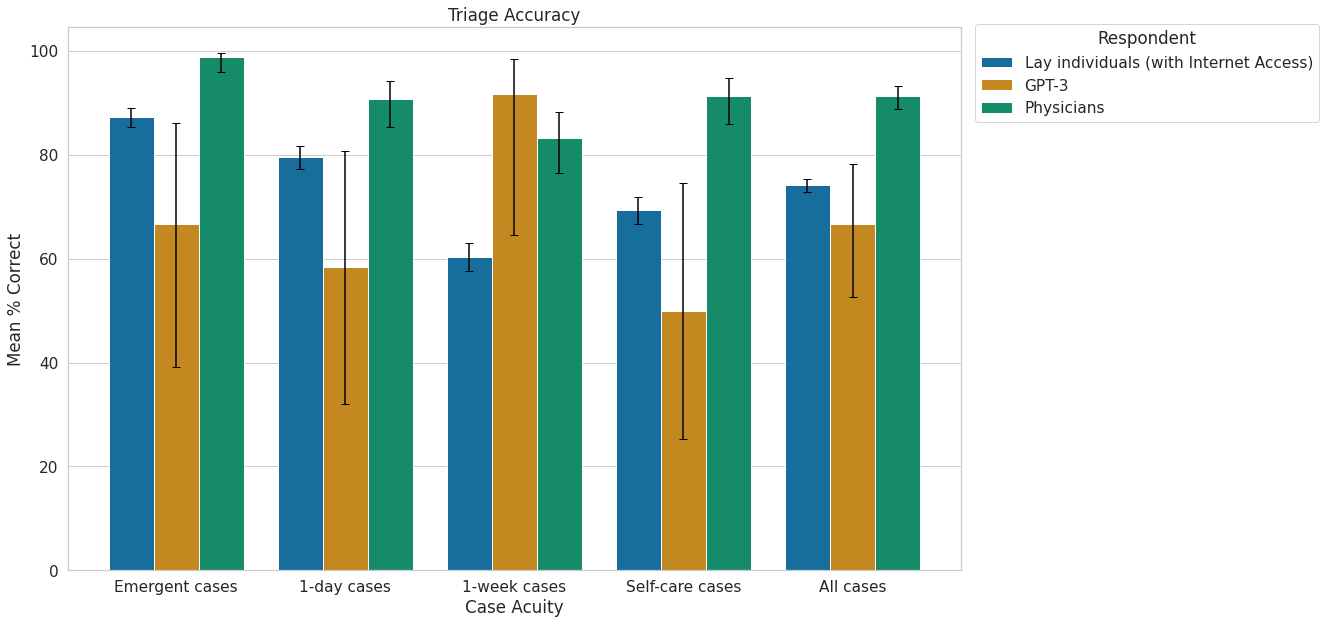

In [13]:
row_order = ["Emergent", "1-day", "1-week", "Self-care", "All"]

fig, ax = plt.subplots(figsize=(16, 10))
g = sns.barplot(data=triage_perf, 
            x='Case Acuity', 
            y='Mean',
            hue='Respondent',
            ax=ax,
            order=row_order,
            palette="colorblind"
           )
g.legend(loc='upper right', bbox_to_anchor=(1.41, 1.02), title="Respondent")
g.set_xlabel("Case Acuity")
g.set_ylabel("Mean % Correct")
g.set_xticklabels([a.get_text() + " cases" for a in ax.get_xticklabels()])
g.set_title("Triage Accuracy")

tmp = triage_perf.set_index(["Case Acuity", "Respondent"]).\
    loc[[(case, respondent.get_text()) for respondent in ax.legend_.get_texts() for case in row_order]]
tmp["LB"] = -(tmp["LB"]-tmp["Mean"])
tmp["UB"] = tmp["UB"] - tmp["Mean"]
                                                     
ax.errorbar(x=[patch.get_x()+patch.get_width()/2 for patch in ax.patches], 
            y=[patch.get_height() for patch in ax.patches], 
            yerr=tmp[["LB", "UB"]].values.T,
            ls='none', fmt='k', capsize=4);